# Job Recommendation Model: Skill and Region-Based Matching

A TensorFlow-powered model that uses LSTM networks and embeddings to recommend jobs based on a user's skills and preferred region, ensuring personalized and accurate job matching.

## **1st Step: Install the Library**

Install all necessary libraries to start using this model.

We use `Pandas`, `NumPy`, `TensorFlow`, `matplotlib`.`pyplot`, and `sklearn`.

In [1]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import json

## **2nd Step: Get The Dataset**
Get the dataset from GitHub

We need 3 dataset such as `job_offer.csv`, `company.csv`, `regency.csv`

3 dataset that contain dummy data to train the model

In [4]:
# Load datasets from GitHub
job_offer_df = pd.read_csv('https://raw.githubusercontent.com/MadRapz/Machine-Learning-PEMUDA/refs/heads/main/Dataset/job_offer9.csv')
company_df = pd.read_csv('https://raw.githubusercontent.com/MadRapz/Machine-Learning-PEMUDA/refs/heads/main/Dataset/company.csv')
regency_df = pd.read_csv('https://raw.githubusercontent.com/MadRapz/Machine-Learning-PEMUDA/refs/heads/main/Dataset/regency.csv')

# Merge datasets
df = job_offer_df.merge(
    regency_df, on='id_regency', how='left'
).merge(
    company_df[['id_company', 'name_company']], on='id_company', how='left'
)

# Display the merged DataFrame
print("Merged Dataset Sample:")
print(df.head())

Merged Dataset Sample:
   id_job_offer           position  id_regency   job_type  \
0             1     UI/UX Designer           7  Full-Time   
1             2  Marketing Manager           6  Full-Time   
2             3  Software Engineer           6  Full-Time   
3             4        QA Engineer           5  Freelance   
4             5  Software Engineer           5  Full-Time   

                                             summary  id_company  \
0  Responsible for the ui/ux designer in the tech...          65   
1           Driving excellence in the retail market.          13   
2  Responsible for the software engineer in the m...          43   
3  Responsible for the qa engineer in the educati...          91   
4  Responsible for the software engineer in the f...          14   

                                           req_skill regency_name  \
0  Figma , Adobe XD , Sketch, HTML , CSS , Typogr...   Karangasem   
1  Strategic Thinking, Digital Marketing Expertis...     Jembra

## **3rd Step: Tokenize and Pad Input Data**
Convert the `skills` and `regency` text columns into numerical sequences using tokenization and apply padding to ensure uniform sequence lengths.

In [5]:
# Handle missing values for skills and regency
df['skills'] = df['req_skill'].fillna('')
df['regency'] = df['regency_name'].fillna('')

# Tokenize and pad skills
tokenizer_skill = Tokenizer()
tokenizer_skill.fit_on_texts(df['skills'])
skill_sequences = tokenizer_skill.texts_to_sequences(df['skills'])
skill_max_len = max([len(x) for x in skill_sequences])
skill_padded = pad_sequences(skill_sequences, maxlen=skill_max_len, padding='post')

# Tokenize and pad regency
tokenizer_regency = Tokenizer()
tokenizer_regency.fit_on_texts(df['regency'])
regency_sequences = tokenizer_regency.texts_to_sequences(df['regency'])
regency_max_len = max([len(x) for x in regency_sequences])
regency_padded = pad_sequences(regency_sequences, maxlen=regency_max_len, padding='post')

# Display samples
print("Tokenized Skills Sample:", skill_sequences[:5])
print("Padded Skills Sample:", skill_padded[:5])
print("\nTokenized Regency Sample:", regency_sequences[:5])
print("Padded Regency Sample:", regency_padded[:5])

Tokenized Skills Sample: [[33, 9, 34, 35, 5, 6, 36, 37, 38], [44, 18, 45, 46, 47, 19, 31, 48, 49, 50, 51, 52, 53, 2, 30, 2, 32, 54, 2, 55, 56, 2], [21, 102, 103, 104, 4, 105, 12, 12, 3, 14, 6, 5, 10, 26, 1, 23, 106, 107], [1, 8, 57, 1, 8, 58, 59, 1, 60, 1, 61, 62, 63, 64, 18], [21, 102, 103, 104, 4, 105, 12, 12, 3, 14, 6, 5, 10, 26, 1, 23, 106, 107]]
Padded Skills Sample: [[ 33   9  34  35   5   6  36  37  38   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [ 44  18  45  46  47  19  31  48  49  50  51  52  53   2  30   2  32  54
    2  55  56   2   0   0   0   0]
 [ 21 102 103 104   4 105  12  12   3  14   6   5  10  26   1  23 106 107
    0   0   0   0   0   0   0   0]
 [  1   8  57   1   8  58  59   1  60   1  61  62  63  64  18   0   0   0
    0   0   0   0   0   0   0   0]
 [ 21 102 103 104   4 105  12  12   3  14   6   5  10  26   1  23 106 107
    0   0   0   0   0   0   0   0]]

Tokenized Regency Sample: [[5], [8], [8], [1], [1]]
Padded Regency Sample: [[5

## **4th Step: Define the Model Architecture**

The model processes `skills` and `regency` inputs using `Embedding` and `LSTM` layers to capture relationships within the data. These outputs are combined and passed through a Dense layer to predict job recommendations based on both inputs.

In [6]:
# Define input layers
skill_input = Input(shape=(skill_max_len,), name='skill_input')
regency_input = Input(shape=(regency_max_len,), name='regency_input')

# Embedding layers
skill_embedding = Embedding(input_dim=len(tokenizer_skill.word_index) + 1, output_dim=50, name='skill_embedding')(skill_input)
regency_embedding = Embedding(input_dim=len(tokenizer_regency.word_index) + 1, output_dim=50, name='regency_embedding')(regency_input)

# LSTM layers
skill_lstm = LSTM(100, name='skill_lstm')(skill_embedding)
regency_lstm = LSTM(100, name='regency_lstm')(regency_embedding)

# Concatenate outputs
combined = Concatenate(name='concatenate_layer')([skill_lstm, regency_lstm])

# Dense output layer
output = Dense(len(tokenizer_skill.word_index) + 1, activation='softmax', name='output')(combined)

# Define the model
model = Model(inputs=[skill_input, regency_input], outputs=output, name='job_recommendation_model')

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

Model: "job_recommendation_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ skill_input (InputLayer)  │ (None, 26)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ regency_input             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ skill_embedding           │ (None, 26, 50)         │          7,750 │ skill_input[0][0]      │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ regency_embedding         │ (None, 1, 50)          │            500 │ regency_input[0][0]    │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ skill_lstm (LSTM)         │ (None, 100)            │         60,400 │ skill_embedding[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ regency_lstm (LSTM)       │ (None, 100)            │         60,400 │ regency_embedding[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_layer         │ (None, 200)            │              0 │ skill_lstm[0][0],      │
│ (Concatenate)             │                        │                │ regency_lstm[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 155)            │         31,155 │ concatenate_layer[0][… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 160,205 (625.80 KB)

 Trainable params: 160,205 (625.80 KB)

 Non-trainable params: 0 (0.00 B)

## **5th Step: Prepare Labels and Train the Model**

Align the input data and prepare the labels for training. The model learns to predict the next token in the skills sequence based on the given input.

In [9]:
# Prepare labels (target values) from the last token in each skill sequence
y = []
for seq in skill_sequences:
    if len(seq) > 1:
        y.append(seq[-1])  # Take the last token as the target

# Convert labels to one-hot encoding
y = np.eye(len(tokenizer_skill.word_index) + 1)[y]

# Align inputs with labels
skill_padded = skill_padded[:len(y)]
regency_padded = regency_padded[:len(y)]

## **Step 7: Train the Model**
Split data into training and validation sets, then train the model.

In [10]:
from sklearn.model_selection import train_test_split

# Split data into training and validation sets
X_train_skill, X_val_skill, X_train_regency, X_val_regency, y_train, y_val = train_test_split(
    skill_padded, regency_padded, y, test_size=0.2, random_state=42
)

# Train the model and save history
history = model.fit(
    [X_train_skill, X_train_regency], y_train,
    validation_data=([X_val_skill, X_val_regency], y_val),
    epochs=20, verbose=1
)

Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.8566 - loss: 0.5670 - val_accuracy: 0.8353 - val_loss: 0.6306
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8003 - loss: 0.6742 - val_accuracy: 0.8235 - val_loss: 0.6202
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8934 - loss: 0.5336 - val_accuracy: 0.8353 - val_loss: 0.5629
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9068 - loss: 0.4696 - val_accuracy: 0.8588 - val_loss: 0.5008
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9073 - loss: 0.4174 - val_accuracy: 0.8824 - val_loss: 0.4421
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9312 - loss: 0.3844 - val_accuracy: 0.9059 - val_loss: 0.3924
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9411 - loss: 0.3431 - val_accuracy: 0.9412 - val_loss: 0.3531
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9404 - loss: 0.3124 - val_accuracy: 1.0000 - v

## **Step 8: Visualize Training Progress**
Plot training and validation loss and accuracy.


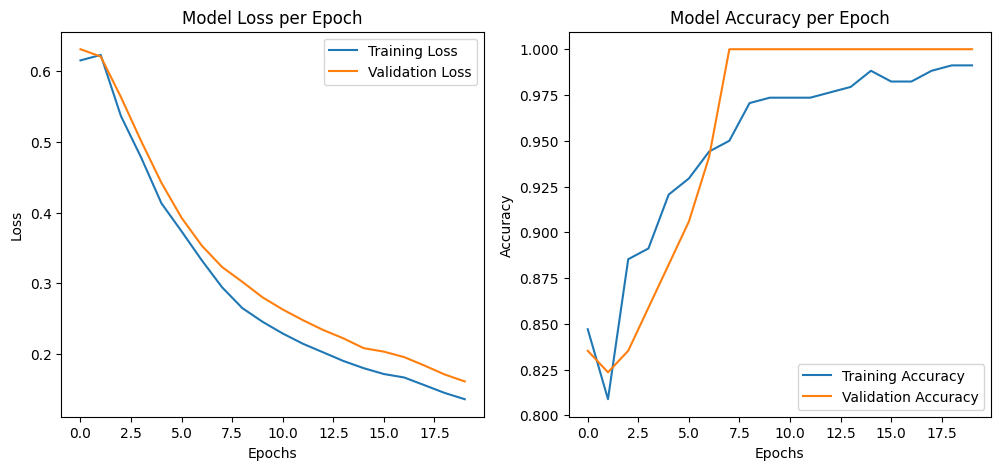

In [12]:
import matplotlib.pyplot as plt

# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

## **Step 9: Save the Model and Tokenizers**
Save the trained model and tokenizers for later use.

In [13]:
# Save the model
model.save("tf_model.h5")

# Save tokenizers
with open("tokenizer_skill.json", "w") as f:
    f.write(tokenizer_skill.to_json())

with open("tokenizer_regency.json", "w") as f:
    f.write(tokenizer_regency.to_json())


## **Step 10: Generate Predictions**
Use the model to generate text and predict top job offers.

In [14]:
# Function to generate text
def generate_text(skill_seed, regency_seed, next_words):
    for _ in range(next_words):
        skill_seq = tokenizer_skill.texts_to_sequences([skill_seed])[0]
        skill_seq = pad_sequences([skill_seq], maxlen=skill_max_len, padding='post')

        regency_seq = tokenizer_regency.texts_to_sequences([regency_seed])[0]
        regency_seq = pad_sequences([regency_seq], maxlen=regency_max_len, padding='post')

        predicted = model.predict([skill_seq, regency_seq], verbose=0)
        output_word = ""
        for word, index in tokenizer_skill.word_index.items():
            if index == np.argmax(predicted):
                output_word = word
                break

        skill_seed += " " + output_word
    return skill_seed

# Function to predict top job offers
def predict_top_job_offers(skill_seed, regency_seed):
    skill_seq = tokenizer_skill.texts_to_sequences([skill_seed])[0]
    skill_seq = pad_sequences([skill_seq], maxlen=skill_max_len, padding='post')

    regency_seq = tokenizer_regency.texts_to_sequences([regency_seed])[0]
    regency_seq = pad_sequences([regency_seq], maxlen=regency_max_len, padding='post')

    predicted = model.predict([skill_seq, regency_seq], verbose=0)
    top_indices = np.argsort(predicted[0])[::-1]

    # Prioritize by regency, then match top skills
    filtered_df = df[df['regency'] == regency_seed]
    top_job_offers = []

    for predicted_index in top_indices:
        for idx, row in filtered_df.iterrows():
            skill_sequence = tokenizer_skill.texts_to_sequences([row['skills']])[0]
            if len(skill_sequence) > 0 and skill_sequence[-1] == predicted_index:
                if all(word in row['skills'] for word in skill_seed.split()):
                    top_job_offers.append({
                        "id_job_offer": row['id_job_offer'],
                        "company_name": row['name_company'],
                        "position": row['position'],
                        "required_skills": row['req_skill']
                    })
                    if len(top_job_offers) == 10:
                        return top_job_offers

    return top_job_offers

## **Step 11: Test the Model**
Test the model with example data.

In [15]:
seed_skill = "Figma Adobe XD"
seed_regency = "Denpasar"
generated_text = generate_text(seed_skill, seed_regency, next_words=10)
top_job_offers = predict_top_job_offers(seed_skill, seed_regency)

print("Generated Text:", generated_text)
print("Top 10 Predicted Job Offers:")
for offer in top_job_offers:
    print(f"ID: {offer['id_job_offer']}, Company: {offer['company_name']}, Position: {offer['position']}, Skills: {offer['required_skills']}")

Generated Text: Figma Adobe XD bootstrap bootstrap bootstrap bootstrap sql sql theory theory theory theory
Top 10 Predicted Job Offers:
ID: 21, Company: PT Nusantara Teknologi, Position: UI/UX Designer, Skills: Figma , Adobe XD , Sketch, HTML , CSS , Typography , Color Theory
ID: 225, Company: PT Sinar Sukses, Position: UI/UX Designer, Skills: Figma , Adobe XD , Sketch, HTML , CSS , Typography , Color Theory
ID: 298, Company: PT Sukses Makmur, Position: UI/UX Designer, Skills: Figma , Adobe XD , Sketch, HTML , CSS , Typography , Color Theory
ID: 471, Company: PT Gemilang Bersama, Position: UI/UX Designer, Skills: Figma , Adobe XD , Sketch, HTML , CSS , Typography , Color Theory
ID: 603, Company: PT Prima Industri, Position: UI/UX Designer, Skills: Figma , Adobe XD , Sketch, HTML , CSS , Typography , Color Theory
ID: 624, Company: PT Harapan Sejahtera, Position: UI/UX Designer, Skills: Figma , Adobe XD , Sketch, HTML , CSS , Typography , Color Theory
ID: 804, Company: PT Jaya Mulya, Pos